In [1372]:
import torch
from torch import nn
import numpy as np
from scipy.special import expit
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [1373]:
# 1. p low but should be higher
#  p must be > 0.1 to allow for exploration
#  the model learns to rely on existing features (because this one is not given w.h.p.)
#  p > 0.1 is fine (page 36 of the thesis)
# 2. p high but could be lower
#  here the regularizer works
#  and the gradient is almost 0
# trying straight-through estimator...

In [1435]:
def get_data(bs=1000):
    data_x = np.random.randn(bs, 5) ** 2
    data_y = expit((np.sin(data_x[:, 0]))) #+ np.log(np.abs(data_x[:, 4]) ** 0.5))
#     data_y = data_x[:, 0] + data_x[:, 4]
    return torch.from_numpy(data_x).to(torch.float32), torch.from_numpy(data_y).to(torch.float32)

In [1436]:
data_x, data_y = get_data()

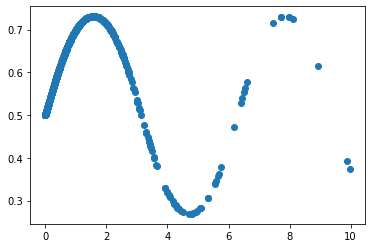

In [1437]:
plt.scatter(data_x[:, 0], data_y)

In [1438]:
p = 0.5

In [1439]:

init_val = torch.from_numpy(np.random.randn(5, 2))

In [1440]:
z = init_val.repeat(10, 1)[:, 0].view(10, 5)

In [1441]:
z * z

tensor([[4.0458, 1.6992, 0.2144, 0.8325, 0.2643],
        [4.0458, 1.6992, 0.2144, 0.8325, 0.2643],
        [4.0458, 1.6992, 0.2144, 0.8325, 0.2643],
        [4.0458, 1.6992, 0.2144, 0.8325, 0.2643],
        [4.0458, 1.6992, 0.2144, 0.8325, 0.2643],
        [4.0458, 1.6992, 0.2144, 0.8325, 0.2643],
        [4.0458, 1.6992, 0.2144, 0.8325, 0.2643],
        [4.0458, 1.6992, 0.2144, 0.8325, 0.2643],
        [4.0458, 1.6992, 0.2144, 0.8325, 0.2643],
        [4.0458, 1.6992, 0.2144, 0.8325, 0.2643]], dtype=torch.float64)

In [1442]:
class Switch(nn.Module):
    def __init__(self):
        super(Switch, self).__init__()
        p = p_init = 0.1
        init_val = np.array([np.log(p), np.log(1 - p)], dtype=np.float32)
        init_val = torch.from_numpy(np.stack([init_val] * 5))
        self.log_probs = nn.Parameter(torch.tensor(init_val, requires_grad=True))
        
    def forward(self, x):
        bs = x.shape[0]
        sm = torch.nn.functional.gumbel_softmax(self.log_probs.repeat(bs, 1),
                                                tau=5.0, hard=True, eps=1e-10, dim=-1)[:, 0].view(bs, 5)
        return x * sm

In [1443]:
?init_val.mean

Docstring:
mean(dim=None, keepdim=False) -> Tensor or (Tensor, Tensor)

See :func:`torch.mean`
Type:      builtin_function_or_method


In [1444]:
class StraightSwitch(nn.Module):
    def __init__(self):
        super(StraightSwitch, self).__init__()
        p = p_init = 0.1
        init_val = np.array([p] * 5, dtype=np.float32)
        self.p = nn.Parameter(torch.tensor(init_val, requires_grad=True))
        
    def forward(self, x):
        bs = x.shape[0]
        p_clamped = torch.clamp(self.p, min=0.01, max=1)
        self.p.data = torch.tensor(p_clamped, requires_grad=True)

        prep = self.p.repeat(bs).view(bs, 5)
        sampled = torch.bernoulli(prep)
        
        x_mean = x.median(0, keepdim=True).values.repeat(x.shape[0], 1).detach()
        
        hard = x.detach() * sampled #+ (x_mean * (1 - sampled))
        soft = x * prep
        
        return hard + soft - soft.detach()

In [1445]:
class NoiseSwitch(nn.Module):
    def __init__(self):
        super(NoiseSwitch, self).__init__()
        s_init = 1.0
        init_val = np.array([s_init] * 5, dtype=np.float32)
        self.sigmas = nn.Parameter(torch.tensor(init_val, requires_grad=True))
        
    def forward(self, x):
        bs = x.shape[0]
#         p_clamped = torch.clamp(self.p, min=0.01, max=1)
#         self.p.data = torch.tensor(p_clamped, requires_grad=True)

        prep = self.sigmas.repeat(bs).view(bs, 5)
#         sampled = torch.bernoulli(prep)
        noise = torch.normal(torch.zeros_like(x), torch.ones_like(x)) * prep
        
#         x_mean = x.median(0, keepdim=True).values.repeat(x.shape[0], 1).detach()
        
#         hard = x.detach() * sampled #+ (x_mean * (1 - sampled))
#         soft = x * prep
        
#         return hard + soft - soft.detach()
        return x + noise * torch.std(x, axis=0, keepdim=True).repeat(x.shape[0], 1) / 2.

In [1446]:
init_val.median(0).values

tensor([-0.5141,  0.7505], dtype=torch.float64)

In [1447]:
#StraightSwitch()(torch.ones(3, 5))

In [1448]:
NoiseSwitch()(torch.ones(3, 5))

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]], grad_fn=<AddBackward0>)

In [1449]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(5, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)
        self.act = torch.sin
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = (self.act(x) + 1) / 2
        return x[:, 0]

In [1450]:
class Seq(nn.Module):
    def __init__(self, *args):
        super(Seq, self).__init__()
        self._models = args
        for i, m in enumerate(args):
            setattr(self, 'model' + str(i), m)
    def forward(self, x):
        for m in self._models:
            x = m(x)
        return x

In [1451]:
mm = Model()
# sw = StraightSwitch()
# sw = Switch()
sw = NoiseSwitch()

In [1452]:
data_x, data_y = get_data()

In [1453]:
losses = []
ps = []
ps1 = []

In [1454]:
m = Seq(sw, mm)
# m = mm
opt = torch.optim.Adam(m.parameters(), lr=1e-4)

In [1455]:
for i in tqdm(range(30000)):
    if i % 1 == 0:
        data_x, data_y = get_data(bs=128)
    opt.zero_grad()
    delta = m(data_x) - data_y
    loss = delta.pow(2).mean() + torch.pow(1 - sw.sigmas, 2).mean() * 1e-4
    loss.backward()
    losses.append(loss.item())
    opt.step()
    if hasattr(sw, 'p'):
        ps.append(sw.p[0].item())
    elif hasattr(sw, 'log_probs'):
        ps.append(np.exp(sw.log_probs[0, 0].item()) / (np.exp(sw.log_probs[0, 0].item()) + np.exp(sw.log_probs[0, 1].item())))
    else:
        ps.append(sw.sigmas[0].item())
        ps1.append(sw.sigmas[1].item())

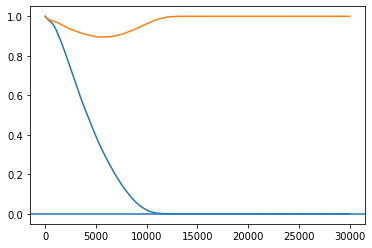

In [1456]:
plt.plot(ps)
plt.plot(ps1)
plt.axhline(0)

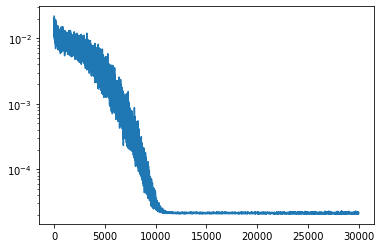

In [1457]:
plt.plot(losses)
plt.yscale('log')

In [1458]:
sw.sigmas

Parameter containing:
tensor([0.0011, 0.9999, 1.0000, 1.0000, 1.0000], requires_grad=True)

In [1404]:
sw(torch.randn(1000, 5)).mean(0)

tensor([ 0.0038,  0.0056,  0.0479, -0.0701,  0.0111], grad_fn=<MeanBackward1>)

In [669]:

def grad_from_lp(tau=0.5, p=0):
    
    logits = torch.tensor(np.array([np.log(p), np.log(1 - p)], dtype=np.float32), requires_grad=True)
    out = torch.nn.functional.gumbel_softmax(logits, tau=2.0, hard=False, eps=1e-10, dim=-1)
    out[0].backward()
#     print(logits.grad, torch.sum(logits.grad))
    return logits.grad[0].item()


def grad_from_p(tau=0.5, p=0.5):
    p = torch.tensor(np.array([p], dtype=np.float32), requires_grad=True)
    
    # this is how it's defined in the Gumbel-Softmax paper
    logit = torch.log(p)#
    logit2 = torch.log(1 - p)#/ (1. - p))
    logits = torch.cat([logit, logit2])
    
    # THIS IS NOT LOGITS -- it's unnormalized log-probabilities
    # they would not sum to 0...
    out = torch.nn.functional.gumbel_softmax(logits, tau=2, hard=False, eps=1e-10, dim=-1)
#     print(out?)
    out[0].backward()
    return p.grad[0]

In [670]:
grad_from_p(p=0.000001)

tensor(872.3837)

In [671]:
grad_from_lp(p=0.5001)

0.10249076783657074

In [672]:
data = np.linspace(0, 1, 100)

/Users/sergia/miniconda3/envs/causal/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


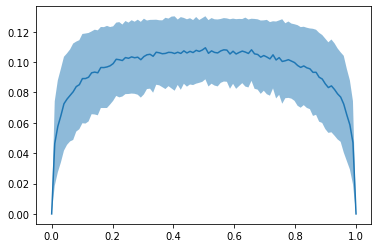

In [673]:
res = [[grad_from_lp(p=d) for _ in range(500)] for d in tqdm(data)]

means = np.mean(res, axis=1)
stds = np.std(res, axis=1)
plt.plot(data, means)
plt.fill_between(data, means - stds, means + stds, alpha=0.5)

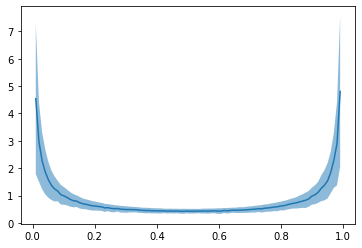

In [305]:
res = [[grad_from_p(p=d) for _ in range(500)] for d in tqdm(data)]

means = np.mean(res, axis=1)
stds = np.std(res, axis=1)
plt.plot(data, means)
plt.fill_between(data, means - stds, means + stds, alpha=0.5)

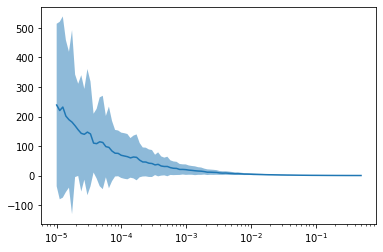

In [320]:
data = np.logspace(-5, np.log10(0.5), 100)

res = [[grad_from_p(p=d) for _ in range(500)] for d in tqdm(data)]

means = np.mean(res, axis=1)
stds = np.std(res, axis=1)
plt.plot(data, means)
plt.fill_between(data, means - stds, means + stds, alpha=0.5)
plt.xscale('log')

In [317]:
data

array([1.00000000e-05, 1.11548656e-05, 1.24431027e-05, 1.38801139e-05,
       1.54830806e-05, 1.72711683e-05, 1.92657562e-05, 2.14906922e-05,
       2.39725784e-05, 2.67410891e-05, 2.98293256e-05, 3.32742119e-05,
       3.71169363e-05, 4.14034437e-05, 4.61849852e-05, 5.15187304e-05,
       5.74684516e-05, 6.41052856e-05, 7.15085847e-05, 7.97668654e-05,
       8.89788666e-05, 9.92547302e-05, 1.10717318e-04, 1.23503680e-04,
       1.37766696e-04, 1.53676898e-04, 1.71424515e-04, 1.91221744e-04,
       2.13305286e-04, 2.37939180e-04, 2.65417958e-04, 2.96070166e-04,
       3.30262293e-04, 3.68403150e-04, 4.10948764e-04, 4.58407824e-04,
       5.11347769e-04, 5.70401565e-04, 6.36275282e-04, 7.09756528e-04,
       7.91723870e-04, 8.83157340e-04, 9.85150146e-04, 1.09892175e-03,
       1.22583245e-03, 1.36739963e-03, 1.52531591e-03, 1.70146940e-03,
       1.89796626e-03, 2.11715586e-03, 2.36165891e-03, 2.63439878e-03,
       2.93863645e-03, 3.27800947e-03, 3.65657552e-03, 4.07886087e-03,
      